In [1]:
import numpy as np
import torch

In [2]:
#parameter setting
num_hidden_state = 3
num_obs = 5
length = 10
num_samples = 1000

In [3]:
#define some useful functions
def generate_HMM_params(num_hidden_state, num_obs):
    # random generate the transition matrix and observation matrix, and compute the stationary distribution
    
    alpha_state = np.ones(num_hidden_state)
    alpha_obs = np.ones(num_obs) / num_obs
    trans_mat = np.random.dirichlet(alpha_state, num_hidden_state)
    obs_mat = np.random.dirichlet(alpha_obs, num_hidden_state)
    tmp = np.ones((num_hidden_state + 1, num_hidden_state))
    tmp[:-1] = np.identity(num_hidden_state) - trans_mat.T
    tmp_v = np.zeros(num_hidden_state + 1)
    tmp_v[-1] = 1
    stat_dist = np.linalg.lstsq(tmp, tmp_v, rcond=None)[0]
    return trans_mat, obs_mat, stat_dist

In [4]:
def generate_HMM_sequences(trans_mat, obs_mat, init_dist, length, num_samples = 1):
    # generate sample sequences from HMM
    
    states = np.zeros((num_samples, length))
    obs = np.zeros((num_samples, length))
    tmp_state = np.argmax(np.random.multinomial(1, init_dist, num_samples), axis = 1)
    #print(tmp_state)
    for i in range(length):
        #print("i: ", i)
        states[:, i] = tmp_state
        for j in range(num_samples):
            obs[j, i] = np.random.multinomial(1, obs_mat[tmp_state[j]]).argmax()
            tmp_state[j] = np.random.multinomial(1, trans_mat[tmp_state[j]]).argmax()
        #print("obs[:, i]: ", obs[:, i])
    return states, obs

In [5]:
def forward_compute(trans_mat, obs_mat, init_dist, obs_to_pos):
    # compute \sum_{h_1,...,h_{pos-1}} P(h_1,...,h_{pos},x_1,...,x_{pos-1})
    pos = obs_to_pos.shape[0] + 1
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    forward = np.zeros((pos, num_hidden_state))
    forward[0] = init_dist
    for i in range(1, pos):
        for j in range(num_hidden_state):
            for k in range(num_hidden_state):
                #print(i, j, k)
                #print(forward[i - 1, k], trans_mat[k, j], obs_mat[k, int(obs_to_pos[i - 1])])
                forward[i, j] += forward[i - 1, k] * trans_mat[k, j] * obs_mat[k, int(obs_to_pos[i - 1])]
    #print("forward: ", forward)
    return forward[pos - 1]

In [6]:
def backward_compute(trans_mat, obs_mat, obs_from_pos):
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    back_length = obs_from_pos.shape[0]
    if (back_length == 0):
        return np.ones(num_hidden_state)
    backward = np.zeros((back_length, num_hidden_state))
    for j in range(num_hidden_state):
         for k in range(num_hidden_state):
            backward[0, j] += trans_mat[j, k] * obs_mat[k, int(obs_from_pos[-1])]
    for i in range(1, back_length):
        for j in range(num_hidden_state):
            for k in range(num_hidden_state):
                backward[i, j] += trans_mat[j, k] * obs_mat[k, int(obs_from_pos[-(i + 1)])] * backward[i - 1, k]
    #print("backward: ", backward)
    return backward[-1]

In [7]:
def x_i_conditional_prob(trans_mat, obs_mat, init_dist, known_X, pos):
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    num_samples = known_X.shape[0]
    length = known_X.shape[1]
    x_pos_conditional_prob = np.zeros((num_samples, num_obs))
    h_pos_conditional_prob = np.zeros((num_samples, num_hidden_state))
    h_all_pos_conditional_prob = np.zeros((num_samples, num_hidden_state))
    for i in range(num_samples):
        #print("x_i_conditional_prob: i=", i)
        sample_obs_vec = known_X[i]
        forward_vec = forward_compute(trans_mat, obs_mat, init_dist, known_X[i, :pos[i]])
        backward_vec = backward_compute(trans_mat, obs_mat, known_X[i, pos[i] + 1:])
        #print("forward_vec: ", forward_vec)
        #print("backward_vec: ", backward_vec)
        h_prob_tmp = forward_vec * backward_vec
        tmp = h_prob_tmp.sum()
        h_prob_tmp /= tmp
        h_pos_conditional_prob[i] = h_prob_tmp
        x_pos_conditional_prob[i] = h_prob_tmp @ obs_mat
        h_all_pos_conditional_prob[i] = h_prob_tmp * obs_mat[:, int(known_X[i, pos[i]])] / x_pos_conditional_prob[i, int(known_X[i, pos[i]])]
    return h_pos_conditional_prob, x_pos_conditional_prob, h_all_pos_conditional_prob

In [8]:
seed = 20211018
np.random.seed(seed)
trans_mat, obs_mat, stat_dist = generate_HMM_params(num_hidden_state, num_obs) # generate parameters for HMM

states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples) # generate sample sequences

pos = np.random.randint(length, size = num_samples)

print("transition matrix")
print(trans_mat)
print("observation matrix")
print(obs_mat)
print("stationary distribution")
print(stat_dist)
print("states and observations, first half of each row is states, only showing first 5: ")
print(np.concatenate((states, obs), axis = 1)[:5])
print("positions, only showing first 5: ", pos[:5])
h, x, hh = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)
print("Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(h[:5])
print("Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(x[:5])
print("Pr[H_i|x_i,x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(hh[:5])

transition matrix
[[0.19038151 0.5603291  0.24928939]
 [0.59211519 0.37810341 0.0297814 ]
 [0.52737761 0.34205379 0.1305686 ]]
observation matrix
[[2.84422161e-01 2.51497236e-01 1.31816210e-02 4.38026768e-01
  1.28722143e-02]
 [1.50940815e-01 6.59969385e-01 1.64551320e-02 2.15946003e-02
  1.51040067e-01]
 [9.01408117e-03 9.45219115e-01 4.57668030e-02 7.87716140e-11
  4.61558184e-10]]
stationary distribution
[0.41619456 0.44908825 0.1347172 ]
states and observations, first half of each row is states, only showing first 5: 
[[1. 1. 0. 0. 0. 2. 0. 1. 0. 1. 0. 1. 0. 3. 3. 1. 1. 0. 3. 1.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 4. 3. 3. 4. 1. 0. 4. 1. 1.]
 [0. 2. 0. 2. 0. 2. 2. 2. 1. 0. 3. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [0. 2. 2. 0. 1. 0. 2. 1. 2. 0. 1. 1. 1. 3. 1. 0. 1. 1. 1. 2.]
 [1. 0. 1. 0. 2. 1. 1. 1. 0. 1. 4. 1. 4. 1. 1. 0. 1. 0. 3. 3.]]
positions, only showing first 5:  [9 4 6 2 1]
Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:
[[0.21892801 0.54738046 0.

In [9]:
logh = np.log(h)

In [10]:
from torch import nn
from torch.utils import data

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linearnetwork = nn.Sequential(
            nn.Linear(num_obs, num_hidden_state, bias=False)
        )
    
    def forward(self, logh, ind_x):
        logits = self.linearnetwork(ind_x)
        return nn.Softmax(dim = 1)(logh + logits)

In [12]:
x_one_hot = np.zeros((num_samples, num_obs))
for i in range(num_samples):
    x_one_hot[i, int(obs[i, pos[i]])] = 1
print(pos[:9])
print(obs[:9])
print(x_one_hot[:9])

[9 4 6 2 1 3 1 2 1]
[[0. 1. 0. 3. 3. 1. 1. 0. 3. 1.]
 [1. 4. 3. 3. 4. 1. 0. 4. 1. 1.]
 [3. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 3. 1. 0. 1. 1. 1. 2.]
 [4. 1. 4. 1. 1. 0. 1. 0. 3. 3.]
 [1. 0. 1. 0. 0. 3. 1. 0. 3. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 3.]
 [4. 3. 0. 1. 1. 1. 0. 3. 1. 3.]
 [3. 1. 0. 2. 4. 3. 1. 3. 1. 1.]]
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [13]:
features1, features2, labels = logh, x_one_hot, hh

In [14]:
# Model parameters.
lr = 1
epochs = 1000
batch_size = 100

In [15]:
dataset = data.TensorDataset(torch.FloatTensor(features1), torch.FloatTensor(features2), torch.FloatTensor(labels))
train_dl = data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [16]:
net = NeuralNetwork()

In [17]:
loss = nn.MSELoss()

In [18]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [19]:
total_loss_lst = []
for i in range(epochs):
    total_loss = 0
    for X1, X2, y in train_dl:
        l = loss(net(X1, X2) ,y)
        total_loss += l
        trainer.zero_grad()
        l.backward()
        trainer.step()
    if (i % 100 == 0):
        print("epoch: ", i)
        print("loss: ", total_loss)
        total_loss_lst.append(total_loss)

epoch:  0
loss:  tensor(0.3448, grad_fn=<AddBackward0>)
epoch:  100
loss:  tensor(0.0037, grad_fn=<AddBackward0>)
epoch:  200
loss:  tensor(0.0016, grad_fn=<AddBackward0>)
epoch:  300
loss:  tensor(0.0011, grad_fn=<AddBackward0>)
epoch:  400
loss:  tensor(0.0009, grad_fn=<AddBackward0>)
epoch:  500
loss:  tensor(0.0007, grad_fn=<AddBackward0>)
epoch:  600
loss:  tensor(0.0006, grad_fn=<AddBackward0>)
epoch:  700
loss:  tensor(0.0005, grad_fn=<AddBackward0>)
epoch:  800
loss:  tensor(0.0005, grad_fn=<AddBackward0>)
epoch:  900
loss:  tensor(0.0004, grad_fn=<AddBackward0>)


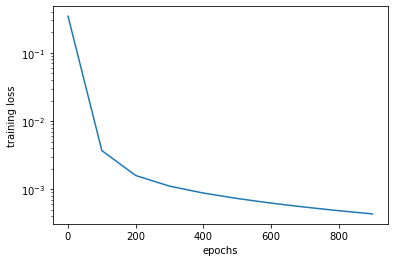

In [20]:
import matplotlib.pyplot as plt
x_lst = list(range(0, 1000, 100))
plt.plot(x_lst, total_loss_lst)
plt.yscale('log')
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.show()

In [50]:
print("learned matrix:")
print(net.linearnetwork[0].weight.data.numpy())
print("log(O):")
print(np.log(obs_mat))

learned matrix:
[[ 1.2678822  -1.0084215  -0.48770857  2.355959   -0.92696136]
 [ 0.63277674 -0.04366085 -0.26590344 -0.7576392   1.6483612 ]
 [-1.3984219   0.3155619   0.7570097  -1.1210496  -1.0172684 ]]
log(O):
[[ -1.25729566  -1.38032328  -4.32893177  -0.82547526  -4.35268422]
 [ -1.89086747  -0.41556183  -4.10711787  -3.83531198  -1.89021013]
 [ -4.70896735  -0.05633851  -3.08419628 -23.26446841 -21.49641299]]


In [25]:
net.eval()

NeuralNetwork(
  (linearnetwork): Sequential(
    (0): Linear(in_features=5, out_features=3, bias=False)
  )
)

In [29]:
states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples) # generate sample sequences

pos = np.random.randint(length, size = num_samples)

print("transition matrix:")
print(trans_mat)
print("observation matrix:")
print(obs_mat)
print("stationary distribution:")
print(stat_dist)
print("states and observations, first half of each row is states, only showing first 5:")
print(np.concatenate((states, obs), axis = 1)[:5])
print("positions, only showing first 5: ", pos[:5])
h, x, hh = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)
print("Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(h[:5])
print("Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(x[:5])
print("Pr[H_i|x_i,x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(hh[:5])

transition matrix:
[[0.19038151 0.5603291  0.24928939]
 [0.59211519 0.37810341 0.0297814 ]
 [0.52737761 0.34205379 0.1305686 ]]
observation matrix:
[[2.84422161e-01 2.51497236e-01 1.31816210e-02 4.38026768e-01
  1.28722143e-02]
 [1.50940815e-01 6.59969385e-01 1.64551320e-02 2.15946003e-02
  1.51040067e-01]
 [9.01408117e-03 9.45219115e-01 4.57668030e-02 7.87716140e-11
  4.61558184e-10]]
stationary distribution:
[0.41619456 0.44908825 0.1347172 ]
states and observations, first half of each row is states, only showing first 5:
[[1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 3. 2. 1. 1. 1. 0. 3. 0. 1.]
 [2. 1. 0. 1. 1. 0. 2. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 0. 2. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 3. 1. 3. 1. 1.]
 [2. 2. 1. 0. 2. 0. 1. 0. 1. 1. 1. 1. 1. 3. 1. 0. 1. 3. 1. 1.]
 [1. 0. 0. 1. 0. 0. 0. 2. 0. 1. 1. 4. 0. 1. 3. 2. 3. 1. 3. 4.]]
positions, only showing first 5:  [4 0 5 4 3]
Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:
[[0.57212268 0.33122139 

In [30]:
x_one_hot = np.zeros((num_samples, num_obs))
for i in range(num_samples):
    x_one_hot[i, int(obs[i, pos[i]])] = 1
print(pos[:9])
print(obs[:9])
print(x_one_hot[:9])

[4 0 5 4 3 4 8 3 5]
[[1. 3. 2. 1. 1. 1. 0. 3. 0. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 3. 1. 3. 1. 1.]
 [1. 1. 1. 3. 1. 0. 1. 3. 1. 1.]
 [1. 4. 0. 1. 3. 2. 3. 1. 3. 4.]
 [1. 3. 1. 1. 3. 1. 3. 1. 1. 0.]
 [0. 4. 3. 0. 1. 3. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 3. 1. 0. 1. 3.]
 [1. 1. 3. 1. 1. 1. 3. 1. 3. 1.]]
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [31]:
features1, features2, labels = logh, x_one_hot, hh

In [32]:
test_dataset = data.TensorDataset(torch.FloatTensor(features1), torch.FloatTensor(features2), torch.FloatTensor(labels))
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=num_samples, shuffle=False)

In [54]:
for X1, X2, Y in test_dl:
    print(np.linalg.norm((net(X1, X2) - Y).detach().numpy()) ** 2 / num_samples)
    print((net(X1, X2)-Y)[:10])
    print(np.linalg.norm((Y).detach().numpy()) ** 2 / num_samples)
    break

0.04703928393370211
tensor([[-0.2306,  0.0853,  0.1453],
        [-0.1078,  0.0045,  0.1033],
        [-0.0069,  0.0028,  0.0041],
        [ 0.0565,  0.0666, -0.1232],
        [ 0.3338, -0.1098, -0.2240],
        [-0.0163,  0.0112,  0.0051],
        [-0.1163,  0.0343,  0.0820],
        [-0.2585,  0.0767,  0.1818],
        [-0.0449, -0.0686,  0.1135],
        [ 0.0255, -0.0305,  0.0050]], grad_fn=<SliceBackward>)
0.5878564137803042


In [49]:
for X1, X2, y in train_dl:
    print(X1[0])
    print(X2[0])
    print(net(X1, X2)[0])
    print(y[0])
    print(net.linearnetwork[0].weight.data.numpy())
    print(X2[2].numpy().T @ np.log(obs_mat.T) + X1[0].numpy())
    print(X2[2].numpy().T @ net.linearnetwork[0].weight.data.numpy().T + X1[0].numpy())
    print(X2[2].numpy().T @ (np.log(obs_mat.T) - net.linearnetwork[0].weight.data.numpy().T))
    print(np.log(obs_mat))
    break

tensor([-1.5190, -0.6026, -1.4538])
tensor([0., 1., 0., 0., 0.])
tensor([0.0864, 0.5669, 0.3467], grad_fn=<SelectBackward>)
tensor([0.0864, 0.5669, 0.3467])
[[ 1.2678822  -1.0084215  -0.48770857  2.355959   -0.92696136]
 [ 0.63277674 -0.04366085 -0.26590344 -0.7576392   1.6483612 ]
 [-1.3984219   0.3155619   0.7570097  -1.1210496  -1.0172684 ]]
[-2.89933561 -1.01817301 -1.51009174]
[-2.5274339  -0.64627206 -1.1381913 ]
[-0.37190174 -0.37190098 -0.3719004 ]
[[ -1.25729566  -1.38032328  -4.32893177  -0.82547526  -4.35268422]
 [ -1.89086747  -0.41556183  -4.10711787  -3.83531198  -1.89021013]
 [ -4.70896735  -0.05633851  -3.08419628 -23.26446841 -21.49641299]]


In [46]:
states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples) # generate sample sequences

pos = np.random.randint(length, size = num_samples)

print("transition matrix")
print(trans_mat)
print("observation matrix")
print(obs_mat)
print("stationary distribution")
print(stat_dist)
print("states and observations, first half of each row is states")
print(np.concatenate((states, obs), axis = 1))
print("positions: ", pos)
h, x, hh = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)
print("Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j]:")
print(h)
print("Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j]:")
print(x)
print("Pr[H_i|x_i,x_-i], j-th row is for j-th sample and i=positions[j]:")
print(hh)

transition matrix
[[0.19038151 0.5603291  0.24928939]
 [0.59211519 0.37810341 0.0297814 ]
 [0.52737761 0.34205379 0.1305686 ]]
observation matrix
[[2.84422161e-01 2.51497236e-01 1.31816210e-02 4.38026768e-01
  1.28722143e-02]
 [1.50940815e-01 6.59969385e-01 1.64551320e-02 2.15946003e-02
  1.51040067e-01]
 [9.01408117e-03 9.45219115e-01 4.57668030e-02 7.87716140e-11
  4.61558184e-10]]
stationary distribution
[0.41619456 0.44908825 0.1347172 ]
states and observations, first half of each row is states
[[1. 0. 1. ... 2. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 1. 0. ... 1. 1. 0.]
 ...
 [0. 0. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 0. 1.]]
positions:  [8 3 0 2 1 5 1 6 6 2 2 6 5 5 1 4 7 7 8 6 0 8 5 9 0 2 8 7 1 9 7 9 1 8 2 4 1
 1 4 7 6 2 7 3 9 2 7 6 2 5 8 7 8 9 0 1 8 0 0 9 5 4 7 6 7 3 4 9 5 8 3 7 8 3
 9 9 0 4 2 6 6 9 1 9 1 5 5 8 1 4 0 3 1 4 7 1 0 6 9 2 2 2 7 4 8 2 7 2 2 6 1
 4 7 6 8 0 1 4 2 1 8 7 3 1 7 8 3 1 7 6 3 5 1 9 1 5 8 3 1 7 7 0 8 6 7 4 3 1
 8 4 8 8 7 8 1 9 2 1 9 1 7 5

In [47]:
logh = np.log(h)
x_one_hot = np.zeros((num_samples, num_obs))
for i in range(num_samples):
    x_one_hot[i, int(obs[i, pos[i]])] = 1
features1, features2, labels = logh, x_one_hot, hh

In [48]:
test_dataset = data.TensorDataset(torch.FloatTensor(features1), torch.FloatTensor(features2), torch.FloatTensor(labels))
test_dl = data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [49]:
for X1, X2, y in test_dl:
    print(net(X1, X2)[:9])
    print(y[:9])
    break

tensor([[0.0864, 0.5669, 0.3467],
        [0.0515, 0.9163, 0.0322],
        [0.3454, 0.4792, 0.1754],
        [0.1011, 0.6800, 0.2189],
        [0.3831, 0.5358, 0.0811],
        [0.6893, 0.3025, 0.0082],
        [0.6368, 0.3457, 0.0175],
        [0.4828, 0.4859, 0.0313],
        [0.0514, 0.6097, 0.3388]], grad_fn=<SliceBackward>)
tensor([[8.6408e-02, 5.6694e-01, 3.4665e-01],
        [5.9853e-02, 9.4015e-01, 1.3646e-09],
        [3.4539e-01, 4.7921e-01, 1.7540e-01],
        [1.0109e-01, 6.7997e-01, 2.1894e-01],
        [3.8309e-01, 5.3579e-01, 8.1121e-02],
        [6.9207e-01, 3.0419e-01, 3.7369e-03],
        [6.4259e-01, 3.4938e-01, 8.0260e-03],
        [4.9077e-01, 4.9475e-01, 1.4478e-02],
        [5.1444e-02, 6.0975e-01, 3.3881e-01]])
